Stuff specific to making this work in Google Colab (insufficient compute on local Mac)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/AdeptId_Exercise/'

import os

os.getcwd()

/content/drive/MyDrive/Colab Notebooks/AdeptId_Exercise


'/content/drive/MyDrive/Colab Notebooks/AdeptId_Exercise'

# Package installation & import

In [ ]:
!pip install sentence_transformers
# Pandas
import pandas as pd
# LLM
from sentence_transformers import SentenceTransformer
# Pickle for saving/loading intermediate files
import pickle
# Multiclass-friendly classifiers from scikit-learn
from sklearn import svm, linear_model, tree, metrics
# Numpy
import numpy as np
# Matplotlib
import matplotlib.pyplot as plt

Data import & basic checks

In [4]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [ ]:
print(train_data.shape)
train_data.head()

In [ ]:
print(test_data.shape)
test_data.ONET_NAME.value_counts()

TRAIN: Min Date 2023-01-19 Max Date 2023-05-16 TEST: Min Date 2022-01-06 Max Date 2022-05-05
(67,)
96       UPMC
200       CNA
521      STNA
579      EDDA
740      Host
         ... 
15785    Cook
16791    COOK
16828    Cook
17740    Host
17794     FWS
Name: TITLE_RAW, Length: 67, dtype: object
(31,)
1816    Seasonal: Guest Advocate (Cashier), General Me...
2034    Accounts Receivable/Medical Insurance Associat...
2536    Process Engineer-Extrusion Plastics\nApr 5, 20...
4227    RRT Specialty, Up To $25K Sign On Bonus, Plus ...
4461    Quality Assurance Manager\nApr 14, 2023\nJob C...
4678    System Director, Operations All Saints Home Me...
6044    General Manager \nApr 7, 2023\nJob Category: O...
6310    LCSW, CSW, LPCC, LPCA - $5K Signing Bonus with...
7639    Contract Management Specialist 1, SG-18, Contr...
7688    LCSW, CSW, LPCC, LPCA - $5K Signing Bonus with...
8446    State of the Art, Nationally Recognized, and T...
8935    T\nNEW!\nPM Forklift Technician\nTMH (Total Ma...
99

<Axes: >

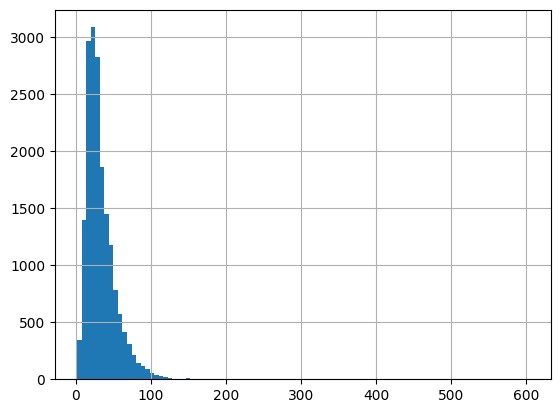

In [ ]:
# Timeframe
print('TRAIN: Min Date', train_data.POSTED.min(), 'Max Date',
      train_data.POSTED.max(), 'TEST: Min Date', test_data.POSTED.min(), 'Max Date',
      test_data.POSTED.max())
# Generally the same

# Prevalence of junk titles (starting with string lengths;
# might be wary of length shorter than a descriptive word or longer than an old tweet)
title_lengths = train_data.TITLE_RAW.str.len()
print(title_lengths[title_lengths < 5].shape)
print(train_data[title_lengths < 5].TITLE_RAW)
print(title_lengths[title_lengths > 140].shape)
print(train_data[title_lengths > 140].TITLE_RAW.head(15))
title_lengths.hist(bins = 100)

<Axes: >

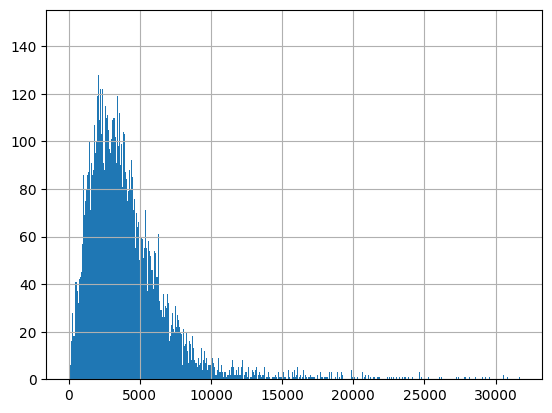

In [ ]:
# Curious about body length as well
body_lengths = train_data.BODY.str.len()
body_lengths.hist(bins = 1000)

In [ ]:
# Comparison of ONET coverage in train/test that may compromise model effectiveness
train_onet_freq = train_data.ONET.value_counts(normalize = True).rename('train')
test_onet_freq = test_data.ONET.value_counts(normalize = True).rename('test')
print(max(train_onet_freq), max(test_onet_freq))
onet_freq_comp = pd.concat([train_onet_freq, test_onet_freq], axis = 1).fillna(0)
onet_freq_comp['diff'] = abs(onet_freq_comp.train - onet_freq_comp.test)
onet_freq_comp.sort_values('diff', ascending = False).head()
# Highest frequency difference is 1.4%

0.053494728621632175 0.039445189233783644


,train,test,diff
29-1141.00,0.053495,0.039445,0.014050
41-2031.00,0.034975,0.022378,0.012597
15-1252.00,0.018631,0.027122,0.008491
41-1011.00,0.024823,0.017686,0.007137
99-9999.00,0.033915,0.039342,0.005427


In [ ]:
# Edge cases: In one but not the other
print('TEST NOT TRAIN:', [o_nm for o_nm in set(test_data.ONET_NAME) if o_nm not in set(train_data.ONET_NAME)])
print('TRAIN NOT TEST:', [o_nm for o_nm in set(train_data.ONET_NAME) if o_nm not in set(test_data.ONET_NAME)])

TEST NOT TRAIN: ['Extruding, Forming, Pressing, and Compacting Machine Setters, Operators, and Tenders', 'Healthcare Practitioners and Technical Workers, All Other', 'Helpers--Brickmasons, Blockmasons, Stonemasons, and Tile and Marble Setters', 'Geothermal Technicians', 'Mining and Geological Engineers, Including Mining Safety Engineers', 'Hoist and Winch Operators', 'Helpers--Pipelayers, Plumbers, Pipefitters, and Steamfitters', 'Graders and Sorters, Agricultural Products', 'Hearing Aid Specialists', 'Forging Machine Setters, Operators, and Tenders, Metal and Plastic', 'Motor Vehicle Operators, All Other', 'Marine Engineers and Naval Architects', 'Air Traffic Controllers', 'Forest and Conservation Workers', 'Customs Brokers', 'Pediatric Surgeons', 'Entertainers and Performers, Sports and Related Workers, All Other', 'First-Line Supervisors of Correctional Officers', 'Health Informatics Specialists', 'Radio, Cellular, and Tower Equipment Installers and Repairers', 'Structural Iron and 

# Feature Engineering
## Fit and encode sentence transformer on title and body text

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# On training data
title_llm = model.encode(train_data.TITLE_RAW)
body_llm = model.encode(train_data.BODY)

In [ ]:
# On test data
title_llm_test = model.encode(test_data.TITLE_RAW)
body_llm_test = model.encode(test_data.BODY)

In [ ]:
# Save of intermediate file
llm_embeddings = {'title': {'train': title_llm, 'test': title_llm_test},
                  'body': {'train': body_llm, 'test': body_llm_test}}
with open('models/llm_embeddings.pickle', 'wb') as handle:
  pickle.dump(llm_embeddings, handle)

In [11]:
# Load of intermediate file
with open('models/llm_embeddings.pickle', 'rb') as handle:
  llm_embeddings = pickle.load(handle)

In [ ]:
print(llm_embeddings['title']['train'].shape)
llm_embeddings['title']['train']

In [ ]:
llm_embeddings

# Modeling & selection

In [ ]:
title_llm_dt = tree.DecisionTreeClassifier(random_state = 4)
title_llm_dt.fit(X = llm_embeddings['title']['train'], y = train_data.ONET)

In [ ]:
title_llm_svc = svm.LinearSVC(multi_class="crammer_singer", random_state = 4)
title_llm_svc.fit(X = llm_embeddings['title']['train'], y = train_data.ONET)

In [ ]:
title_llm_logreg = linear_model.LogisticRegression(
    multi_class = "multinomial", random_state = 4)
title_llm_logreg.fit(X = llm_embeddings['title']['train'], y = train_data.ONET)

In [ ]:
body_llm_dt = tree.DecisionTreeClassifier(random_state = 4)
body_llm_dt.fit(X = llm_embeddings['body']['train'], y = train_data.ONET)

In [ ]:
body_llm_svc = svm.LinearSVC(multi_class="crammer_singer", random_state = 4)
body_llm_svc.fit(X = llm_embeddings['body']['train'], y = train_data.ONET)

In [ ]:
body_llm_logreg = linear_model.LogisticRegression(
    multi_class = "multinomial", random_state = 4)
body_llm_logreg.fit(X = llm_embeddings['body']['train'], y = train_data.ONET)

In [14]:
# Save of intermediate file
classifiers = {'title': {'dt': title_llm_dt, 'svc': title_llm_svc,
                         'logreg': title_llm_logreg},
               'body': {'dt': body_llm_dt, 'svc': body_llm_svc,
                         'logreg': body_llm_logreg}}
with open('models/classifiers.pickle', 'wb') as handle:
  pickle.dump(classifiers, handle)

In [8]:
# Load of intermediate file
with open('models/classifiers.pickle', 'rb') as handle:
  classifiers = pickle.load(handle)

## Accuracy comparison

In [13]:
class_acc = {key: {
    key2: classifiers[key][key2].score(
        llm_embeddings[key]['test'], test_data.ONET)
    for key2 in classifiers[key]} for key in classifiers}

In [14]:
print('Dominant class', 765 / 19394)
class_acc
# Title SVC has the best accuracy/micro-averaged precision/recall, of ~64%
# For purpose of timeboxing, going to use Title Logistic Regression, which unlike
# SVC has a multilabel-friendly predict_proba attribute

Dominant class 0.039445189233783644


{'title': {'dt': 0.3073115396514386,
  'svc': 0.6370011343714551,
  'logreg': 0.5547076415386202},
 'body': {'dt': 0.09059502939053315,
  'svc': 0.4545220171186965,
  'logreg': 0.3936268949159534}}

## Confusion matrix for selected model

In [23]:
cnf_mat = metrics.confusion_matrix(
    test_data.ONET,
    classifiers['title']['logreg'].predict(
        llm_embeddings['title']['test'])
    )


array([[  0,   3,   0, ...,   0,   0,   1],
       [  0, 134,   0, ...,   0,   0,   7],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   2],
       [  0,   0,   0, ...,   0,   0,   2],
       [  0,  26,   0, ...,   0,   0, 377]])

# Multi-label functionality

In [47]:
model = classifiers['title']['logreg']
pred_probs = model.predict_proba(llm_embeddings['title']['test'])
top_2_ind = [np.argsort(-prob)[0:2] for prob in pred_probs]
top_2_onets = np.array([model.classes_[i] for i in top_2_ind])
top_2_onets

array([['53-7065.00', '43-3031.00'],
       ['11-9021.00', '11-9032.00'],
       ['15-1252.00', '15-1211.00'],
       ...,
       ['29-1127.00', '25-1199.00'],
       ['13-1082.00', '11-9199.00'],
       ['99-9999.00', '15-1252.00']], dtype=object)

In [46]:
# Confirming this functionality agrees with the standard predictions
model.predict(llm_embeddings['title']['test'])

array(['53-7065.00', '11-9021.00', '15-1252.00', ..., '29-1127.00',
       '13-1082.00', '99-9999.00'], dtype=object)